In [3]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-08-17 23:20:39.427955: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


Rotation with box

In [1]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage import io
import os
import PIL
from skimage.filters import threshold_otsu, sobel


In [2]:
folder_path = "/home/clr/Thesis/HoughTransform_xray/Humerus/"
outliers_path = "/home/clr/Thesis/HoughTransform_xray/anomalies/"
image_files = os.listdir(folder_path)
outliers = os.listdir(outliers_path)

#removing ".png.png"
for i, x in enumerate(outliers):
    if ".png.png" in x:
        x = x.replace(".png.png",".png")
        outliers[i] = x
        print(x)

for y in outliers:
    if y in image_files:   
        image_files.remove(y)


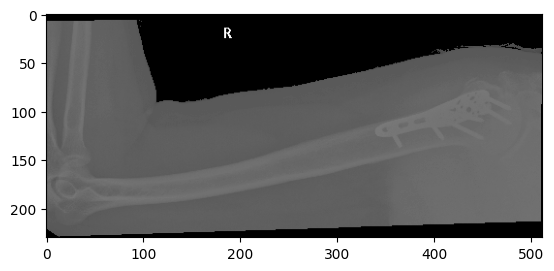

In [2]:
# image_path = "/home/clr/Thesis/pre-processing/Humerus/MURA-v1.1-train-XR_HUMERUS-patient00246-study1_negative-image1.png"
# /home/clr/Thesis/HoughTransform_xray/Humerus
image_path = "/home/clr/Thesis/HoughTransform_xray/Humerus/MURA-v1.1-train-XR_HUMERUS-patient00051-study1_positive-image1.png"
im_gray = np.array(Image.open(image_path).convert('L'))

threshold = threshold_otsu(im_gray)
# threshold -= threshold * 0.2
bina_image = im_gray < threshold
inverted_bina_image = np.logical_not(bina_image)

# Convert the inverted binary image (numpy array) to a Pillow Image object
inverted_binary_image = Image.fromarray(np.uint8(inverted_bina_image) * 255)
plt.imshow(inverted_binary_image, cmap='gray')


#removed image background after thresholding
background_removed_image = np.zeros_like(im_gray)
background_removed_image[inverted_bina_image]  = im_gray[inverted_bina_image]
background_removed_image = Image.fromarray(background_removed_image)

plt.imshow(background_removed_image, cmap='gray')

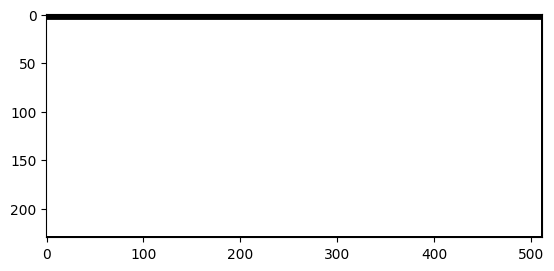

In [4]:
contours, _ = cv2.findContours(np.uint8(background_removed_image), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

best_rect = None
best_rect_area = 0

# Iterate through all contours and find the best fitting rectangle
for contour in contours:
    # Fit a rotated rectangle around the contour
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box_area = rect[1][0] * rect[1][1]

    # Check if the current rectangle has larger area than the previous best
    if box_area > best_rect_area:
        best_rect = box
        best_rect_area = box_area

# Draw the rotated rectangle on the original image
original_image = np.array(background_removed_image)

mask = np.zeros_like(original_image)
cv2.drawContours(mask, [np.int0(best_rect)], 0, (255, 255, 255), cv2.FILLED) # get the rectangl
image_masked = cv2.bitwise_and(original_image, original_image, mask=mask)

#sometimes it cannot detect a rectangle. so we use the original image
if all(element == 255 for row in mask for element in row):
    mask = image_masked

# print(mask)
# # Show the final image with the enclosing rotated rectangle
plt.imshow(mask, cmap='gray')
# plt.imshow(image_masked, cmap='gray')
plt.show()

0.0


/tmp/ipykernel_39710/104026993.py:17: RuntimeWarning: invalid value encountered in sqrt
  length = np.sqrt((x2 - x1)^2 + (y2 - y1)^2)


Text(0.5, 1.0, 'Detected Lines')

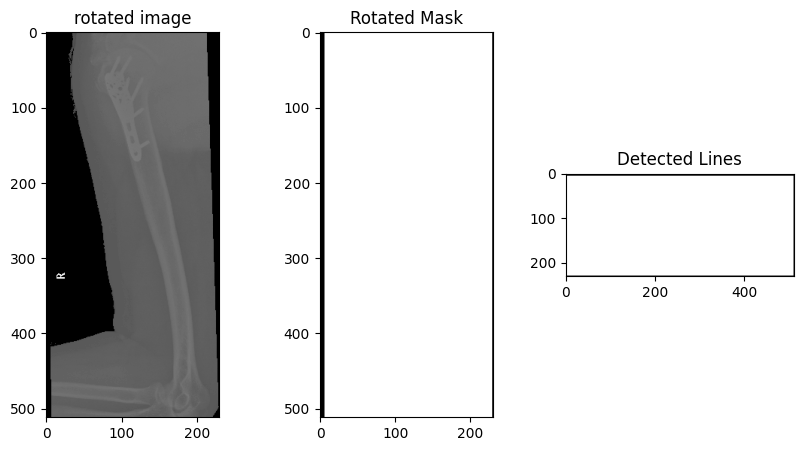

In [5]:
edges = cv2.Canny(mask, 50, 150, apertureSize=3)
lines_list = []

lines = cv2.HoughLinesP(
        edges, # Input edge image
        1, # Distance resolution in pixels
        np.pi/180, # Angle resolution in radians
        threshold=100, # Min number of votes for valid line
        minLineLength=5, # Min allowed length of line
        maxLineGap=5 # Max allowed gap between line for joining them
            )


for points in lines:
    # Extracted points nested in the list
    x1,y1,x2,y2=points[0]
    length = np.sqrt((x2 - x1)^2 + (y2 - y1)^2)
    # Draw the lines joing the points
    # On the original image
    # cv2.line(mask,(x1,y1),(x2,y2),(0, 0, 255),2)
    # Maintain a simples lookup list for points
    # lines_list[0].append([(x1,y1),(x2,y2)])
    lines_list.append(length) #get the length of the line 

longest_line = max(lines_list)
longest_line_index = lines_list.index(longest_line)
longest_line = lines[longest_line_index][0]

#compute for hte angle of the longest line
angle_radians = np.arctan2(longest_line[3] - longest_line[1], longest_line[2] - longest_line[0])
angle_degrees = np.degrees(angle_radians)

# get width and height of the original image
img_original = cv2.imread(image_path)
height, width = img_original.shape[:2]
center = (width // 2, height // 2)

print(angle_degrees)
#if the image is already upright, will not rotate
# had issues with rotation of angles near to 90 degrees; just included images with angles from 80 to 90

if (angle_degrees <=0.6 and angle_degrees >=0):
    rotated_image = np.uint8(background_removed_image)
    rotated_mask = mask
    if height < width:
        rotated_image = cv2.rotate(rotated_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        rotated_mask = cv2.rotate(rotated_mask, cv2.ROTATE_90_COUNTERCLOCKWISE)
 


else:
    if (angle_degrees >= -90 and angle_degrees <= -70) or (angle_degrees <= 90 and angle_degrees >= 70 ) or (angle_degrees <=0 and angle_degrees>= 0.5):

        if (angle_degrees <= 90 and angle_degrees >= 70 ):
            rotated_image = cv2.rotate(np.uint8(background_removed_image), cv2.ROTATE_90_COUNTERCLOCKWISE)
            rotated_mask =cv2.rotate(mask, cv2.ROTATE_90_COUNTERCLOCKWISE)
        elif (angle_degrees >= -90 and angle_degrees <= -70):
            rotated_image = cv2.rotate(np.uint8(background_removed_image), cv2.ROTATE_90_CLOCKWISE)
            rotated_mask =cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE)

        
    else:
        rotation_matrix = cv2.getRotationMatrix2D(center, angle_degrees, 1) #1 is image zoo,
        #making sure the height is always longer. so image is always vertical 
        if height < width:
            rotated_image = cv2.warpAffine(image_masked, rotation_matrix, (width, height))
            rotated_mask = cv2.warpAffine(mask, rotation_matrix, (width, height))
        else:
            rotated_image = cv2.warpAffine(image_masked, rotation_matrix, (height, width))
            rotated_mask = cv2.warpAffine(mask, rotation_matrix, (height, width))


    mask_height, mask_width = rotated_mask.shape[:2]
    if mask_height < mask_width:
        if angle_degrees < -0.6:
            rotated_image = cv2.rotate(rotated_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
            rotated_mask = cv2.rotate(rotated_mask, cv2.ROTATE_90_COUNTERCLOCKWISE)
        elif angle_degrees > 0.6:
            rotated_image = cv2.rotate(rotated_image, cv2.ROTATE_90_CLOCKWISE)
            rotated_mask = cv2.rotate(rotated_mask, cv2.ROTATE_90_CLOCKWISE)


fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(rotated_image, cmap='gray')
ax[0].set_title("rotated image")
ax[1].imshow(rotated_mask, cmap='gray')
ax[1].set_title("Rotated Mask") 
ax[2].imshow(mask, cmap='gray')
ax[2].set_title("Detected Lines")

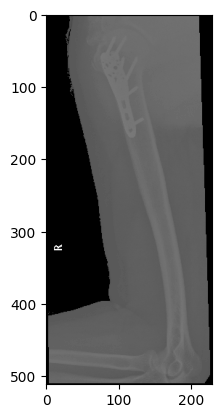

In [7]:
# center image
import numpy
mask_image = numpy.array(rotated_mask)
original_image = numpy.array(rotated_image)

hh, ww = mask_image.shape

# get the contours of the rotated image
contours = cv2.findContours(mask_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

for cntr in contours:
    x,y,w,h = cv2.boundingRect(cntr)
# recenter

startx = (ww - w)//2
starty = (hh - h)//2
result = np.zeros_like(original_image)
result[starty:starty+h,startx:startx+w] = original_image[y:y+h,x:x+w]

plt.imshow(result, cmap='gray')
plt.show()

Text(0.5, 1.0, 'Final Output (rotated + centered)')

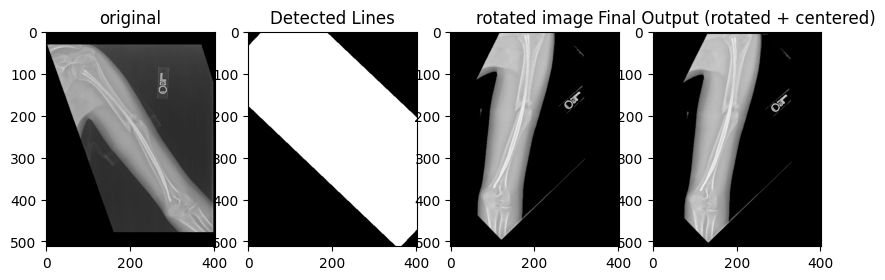

In [46]:
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].imshow(im_gray, cmap='gray')
ax[0].set_title("original")
ax[1].imshow(mask, cmap='gray')
ax[1].set_title("Detected Lines")
ax[2].imshow(rotated_image, cmap='gray')
ax[2].set_title("rotated image")
ax[3].imshow(result, cmap='gray')
ax[3].set_title("Final Output (rotated + centered)")


### Automatic image inversion

Black


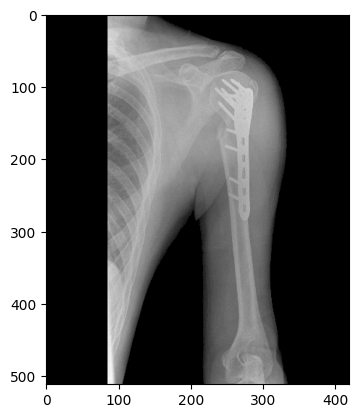

In [23]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2


image_path = "/home/clr/Thesis/HoughTransform_xray/output_images/MURA-v1.1-train-XR_HUMERUS-patient02695-study1_positive-image1.png"
im_gray = np.array(Image.open(image_path).convert('L'))

blackPxNum = np.count_nonzero([im_gray<=100]) #number of black pixels
whitePxNum = im_gray.size - blackPxNum 

if blackPxNum > whitePxNum:
    print("Black")
else:
    print("white")
    im_gray = cv2.bitwise_not(im_gray)


plt.imshow(im_gray , cmap='gray')

In [60]:
from tqdm import tqdm
import time
 
 
for i in tqdm (range (101),
               desc="Loading…",
               ascii=False, ncols=75):
    time.sleep(0.01)
     
print("Complete.")

Loading…: 100%|██████████████████████████| 101/101 [00:01<00:00, 95.46it/s]

Complete.


In [61]:
from tqdm import tqdm
 
for i in tqdm (range (100), desc="Loading..."):
    pass

Loading...: 100%|██████████| 100/100 [00:00<00:00, 1081006.19it/s]
